In this study, we will propose a menthod ECDNN to clean (undersample) the database by removing samples close to the decision boundary.
By integrating with other upsampling method, such as SMOTE, we also propose a hybrid sampling method - SMOTECDNN.

# EditedCDNN

In [ ]:
import numpy as np ##numpy for sorting distance
import scipy##for distance metrics

from imblearn.base import BaseSampler
from sklearn.utils import _safe_indexing

class EditedCDNN(BaseSampler):

    def __init__(self,*,sampling_strategy="auto", n_neighbors=5,kind_sel="cd",n_jobs=None,sampling_type="under-sampling"):
        super().__init__()
        self.n_neighbors = n_neighbors
        self.kind_sel = kind_sel
        self.n_jobs = n_jobs
        self.sampling_strategy=sampling_strategy
        self._sampling_type=sampling_type
        self.sampling_type=sampling_type

        SAMPLING_TARGET_KIND=["minority","majority", "not minority","not majority","all","auto"]

        if isinstance(sampling_strategy, str):
           if sampling_strategy not in SAMPLING_TARGET_KIND:
            raise ValueError(
                f"When 'sampling_strategy' is a string, it needs"
                f" to be one of {SAMPLING_TARGET_KIND}. Got '{sampling_strategy}' "
                f"instead.")

    def _fit_resample(self, X, y):
          #calculate distance
        d=scipy.spatial.distance.cdist(X,X)
        #get k lowest distance and save to Sx
        indexes=np.argsort(d)[:,1:self.n_neighbors+1] # return k indexes of lowest value in d

        idx_under = np.empty((0,), dtype=int)
        input_dim=X.shape[1]

        if self.kind_sel=="all":
          idx_under=np.flatnonzero(np.max(y[indexes],axis=1) == np.min(y[indexes],axis=1))
        elif self.kind_sel=="cd":
          y_pred=[] ##set y_predict list
          for n,index in enumerate(indexes): ##looping through k indexes over the whole test dataset
            Sx = dict()
            for idx in range(self.n_neighbors):
              key = index[idx]
              if y[key] in Sx:
                Sx[y[key]].append(X[key])
              else:
                Sx[y[key]] = []
                Sx[y[key]].append(X[key])

            #calculate current centroids within training dataset
            px = dict()
            for key in Sx:
              sum_item = np.zeros(input_dim)
              for i in range(len(Sx[key])):
                sum_item += Sx[key][i]

              px_item = sum_item/len(Sx[key])

              px[key] = px_item

            #calculate new centroid by adding new test data
            qx = dict()
            for key in Sx:
              sum_item = np.zeros(input_dim)
              for i in range(len(Sx[key])):
                sum_item+=Sx[key][i]
              sum_item += X[n]
              qx_item = sum_item/(len(Sx[key]) + 1)
              qx[key] = qx_item

            #calculate displacement
            theta = dict()
            for key in px:
              if key in qx:
                theta[key] = np.linalg.norm(px[key] - qx[key])

            label=min(theta, key=theta.get)
            y_pred.append(label)

          idx_under=np.flatnonzero(np.array(y_pred)==y)

        minority_class=np.argmin(np.bincount(y))
        majority_class=np.array(np.argmax(np.bincount(y)))
        all_class=np.unique(y)
        non_minority=np.setdiff1d(all_class,minority_class)
        non_majority=np.setdiff1d(all_class,majority_class)

        if self.sampling_strategy in ['not minority','auto']:
          target_class_indices= np.flatnonzero(y == int(minority_class))
          idx_under = np.unique(np.concatenate((idx_under,target_class_indices),axis=0))
        elif self.sampling_strategy=='not majority':
          target_class_indices= np.flatnonzero(y == majority_class)
          idx_under = np.unique(np.concatenate((idx_under,target_class_indices),axis=0))
        elif self.sampling_strategy=='all':
          pass
        elif self.sampling_strategy=='majority':
          for target_class in non_majority:
            target_class_indices= np.flatnonzero(y == target_class)
            idx_under = np.unique(np.concatenate((idx_under,target_class_indices),axis=0))
        elif self.sampling_strategy=='minority':
          for target_class in non_minority:
            target_class_indices= np.flatnonzero(y == target_class)
            idx_under = np.unique(np.concatenate((idx_under,target_class_indices),axis=0))

        self.sample_indices_ = idx_under

        return _safe_indexing(X, idx_under), _safe_indexing(y, idx_under)

    def _more_tags(self):
        return {"sample_indices": True}

In [ ]:
# from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_classification
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

def create_dataset(n_samples=1000,weights=(0.01, 0.01, 0.98), n_classes=3, class_sep=1.5, n_clusters=1,):
    return make_classification(n_samples=n_samples,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=n_clusters,
        weights=list(weights),
        class_sep=class_sep,
        random_state=0,)

In [ ]:
X, y = create_dataset(n_samples=1000, weights=(0.1, 0.2, 0.7))

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

In [ ]:
enn = EditedNearestNeighbours(n_neighbors=5)
X_res, y_res = enn.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({2: 599, 1: 148, 0: 102})


In [ ]:
print('Original train dataset shape %s' % Counter(y))

Original train dataset shape Counter({2: 694, 1: 204, 0: 102})


In [ ]:
for i in np.arange(2,12,1):
  und=EditedCDNN(n_neighbors=i,sampling_strategy='all')
  X_res,y_res=und.fit_resample(X,y)
  print('New dataset shape with auto sampling strategy %s' % Counter(y_res))

New dataset shape with auto sampling strategy Counter({2: 666, 1: 174, 0: 93})
New dataset shape with auto sampling strategy Counter({2: 678, 1: 179, 0: 93})
New dataset shape with auto sampling strategy Counter({2: 679, 1: 180, 0: 95})
New dataset shape with auto sampling strategy Counter({2: 679, 1: 180, 0: 97})
New dataset shape with auto sampling strategy Counter({2: 680, 1: 179, 0: 96})
New dataset shape with auto sampling strategy Counter({2: 681, 1: 180, 0: 96})
New dataset shape with auto sampling strategy Counter({2: 682, 1: 181, 0: 97})
New dataset shape with auto sampling strategy Counter({2: 683, 1: 180, 0: 96})
New dataset shape with auto sampling strategy Counter({2: 684, 1: 179, 0: 96})
New dataset shape with auto sampling strategy Counter({2: 682, 1: 181, 0: 95})


In [ ]:
##default is 'auto': equivalent to 'not minority'.
und=EditedCDNN()
X_res,y_res=und.fit_resample(X,y)
print('New dataset shape with auto sampling strategy %s' % Counter(y_res))

und=EditedCDNN(sampling_strategy="not minority")
X_res,y_res=und.fit_resample(X,y)
print('New dataset shape with not minority sampling strategy %s' % Counter(y_res))

New dataset shape with auto sampling strategy Counter({2: 679, 1: 180, 0: 102})
New dataset shape with not minority sampling strategy Counter({2: 679, 1: 180, 0: 102})


In [ ]:
und=EditedCDNN(sampling_strategy="not majority")
X_res,y_res=und.fit_resample(X,y)
print('New train dataset shape with not majority sampling strategy %s' % Counter(y_res))

New train dataset shape with not majority sampling strategy Counter({2: 694, 1: 180, 0: 97})


In [ ]:
und=EditedCDNN(sampling_strategy="majority")
X_res,y_res=und.fit_resample(X,y)
print('New dataset shape with majority sampling strategy %s' % Counter(y_res))

New dataset shape with majority sampling strategy Counter({2: 679, 1: 204, 0: 102})


In [ ]:
und=EditedCDNN(sampling_strategy="all")
X_res,y_res=und.fit_resample(X,y)
print('New dataset shape %s' % Counter(y_res))

New dataset shape Counter({2: 679, 1: 180, 0: 97})


In [ ]:
und=EditedCDNN(kind_sel="all")
X_res,y_res=und.fit_resample(X,y)
print('New train dataset shape %s' % Counter(y_res))

New train dataset shape Counter({2: 604, 1: 160, 0: 102})


# SMOTE CDNN

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.base import clone

class SMOTECDNN(BaseSampler):

    _sampling_type = "under-sampling"
    def __init__(self,sampling_strategy="auto",random_state=None,smote=None,cdnn=None,n_jobs=None):
        super().__init__()
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.smote = smote
        self.cdnn = cdnn
        self.n_jobs = n_jobs

    def _validate_estimator(self):
        "Private function to validate SMOTE and ECDNN objects"
        if self.smote is not None:
            if isinstance(self.smote, SMOTE):
                self.smote_ = clone(self.smote)
            else:
                raise ValueError(
                    f"smote needs to be a SMOTE object."
                    f"Got {type(self.smote)} instead."
                )
        # Otherwise create a default SMOTE
        else:
            self.smote_ = SMOTE(
                sampling_strategy=self.sampling_strategy,
                random_state=self.random_state,
                n_jobs=self.n_jobs,
            )

        if self.cdnn is not None:
            if isinstance(self.cdnn, EditedCDNN):
                self.cdnn_ = clone(self.cdnn)
            else:
                raise ValueError(
                    f"enn needs to be an EditedCDNN."
                    f" Got {type(self.cdnn)} instead."
                )
        # Otherwise create a default ECDNN
        else:
            self.cdnn_ =  EditedCDNN(
                sampling_strategy="all", n_jobs=self.n_jobs)

    def _fit_resample(self, X, y):
        self._validate_estimator()
        self.sampling_strategy_ = self.sampling_strategy

        X_res, y_res = self.smote_.fit_resample(X, y)
        return self.cdnn_.fit_resample(X_res, y_res)

###Examples

In [ ]:
print('Original dataset shape %s' % Counter(y))
for i in np.arange(2,25,1):
  sme = SMOTECDNN(random_state=1,cdnn=EditedCDNN(n_neighbors=i,sampling_strategy='all'))
  X_res, y_res = sme.fit_resample(X, y)
  print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({2: 694, 1: 204, 0: 102})
Resampled dataset shape Counter({0: 682, 1: 654, 2: 640})
Resampled dataset shape Counter({0: 681, 1: 657, 2: 649})
Resampled dataset shape Counter({0: 683, 1: 654, 2: 653})
Resampled dataset shape Counter({0: 684, 1: 655, 2: 654})
Resampled dataset shape Counter({0: 685, 2: 658, 1: 655})
Resampled dataset shape Counter({0: 685, 2: 660, 1: 653})
Resampled dataset shape Counter({0: 685, 2: 662, 1: 653})
Resampled dataset shape Counter({0: 683, 2: 661, 1: 650})
Resampled dataset shape Counter({0: 686, 2: 663, 1: 654})
Resampled dataset shape Counter({0: 686, 2: 664, 1: 651})
Resampled dataset shape Counter({0: 681, 2: 667, 1: 652})
Resampled dataset shape Counter({0: 681, 2: 666, 1: 649})
Resampled dataset shape Counter({0: 679, 2: 664, 1: 646})
Resampled dataset shape Counter({0: 680, 2: 662, 1: 651})
Resampled dataset shape Counter({0: 681, 2: 662, 1: 652})
Resampled dataset shape Counter({0: 681, 2: 663, 1: 651})
Resampled datas

In [ ]:
from matplotlib.colors import ListedColormap


def plot_resampling_bkp(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)

    cm_bright = ListedColormap(["#e66101","#fdb863", "#b2abd2"])#, "#00F0F0"])

    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res ,cmap=cm_bright, alpha=0.6, edgecolor="k",s=35)
    if title is None:
        # title = f"Resampling with {sampler.__class__.__name__}"
        title = f"{sampler.__class__.__name__}"
    ax.set_title(title,fontsize=16)
    sns.despine(ax=ax, offset=8)

def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)

    ax.scatter(X_res[y_res==0, 0], X_res[y_res==0, 1] ,color="#e66101",marker="^" ,alpha=0.8, edgecolor="k",s=35)
    ax.scatter(X_res[y_res==1, 0], X_res[y_res==1, 1] ,color="#fdb863",marker="o" ,alpha=0.8, edgecolor="k",s=35)
    ax.scatter(X_res[y_res==2, 0], X_res[y_res==2, 1] ,color="#b2abd2",marker="s" ,alpha=0.8, edgecolor="k",s=35)
    if title is None:
        # title = f"Resampling with {sampler.__class__.__name__}"
        title = f"{sampler.__class__.__name__}"
    ax.set_title(title,fontsize=16)
    sns.despine(ax=ax, offset=8)

def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cm_bright = ListedColormap([ "#87CEEB","#FFA500", "#006400"])#, "#00F0F0"])
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.6, c=y, cmap=cm_bright,edgecolor="k",s=35)
    if title is not None:
        ax.set_title(title,fontsize=14)

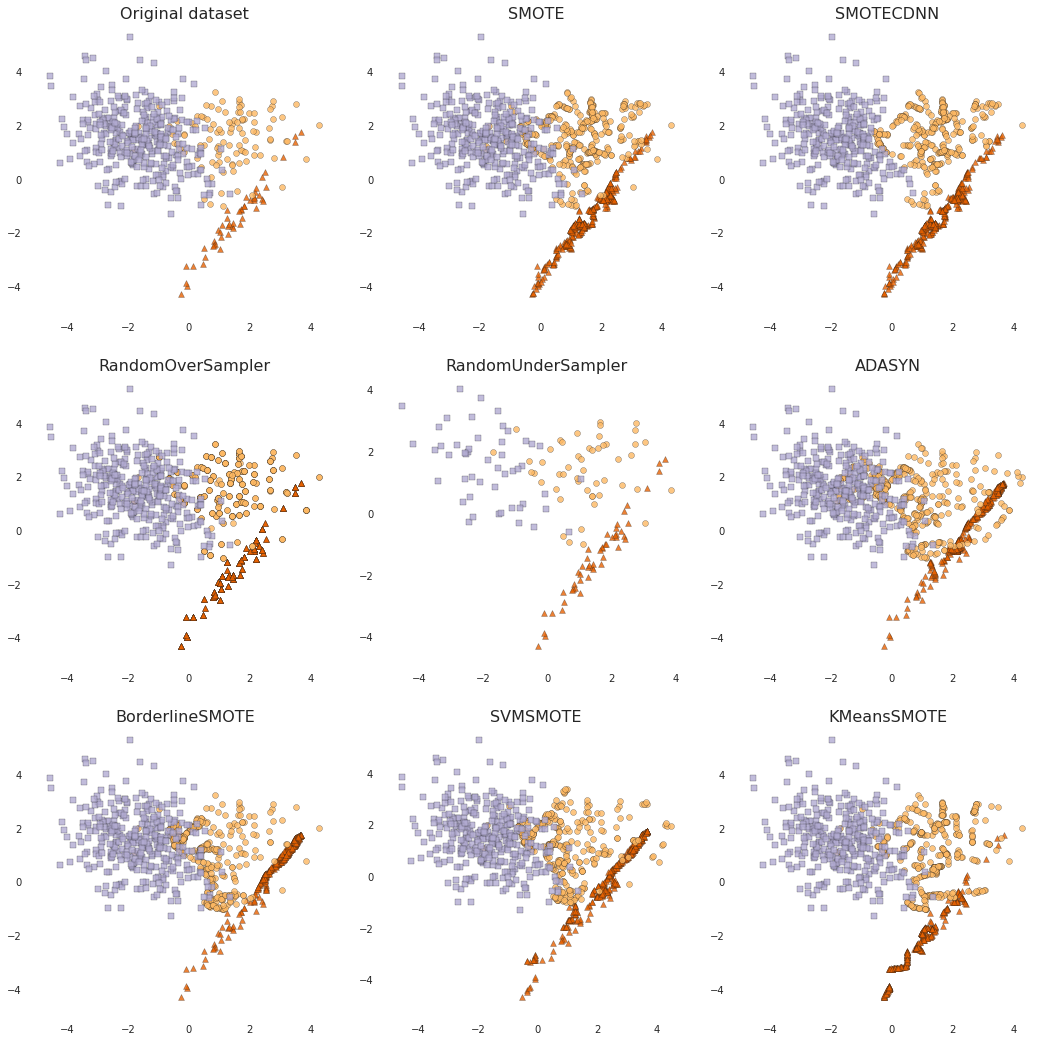

In [ ]:
from imblearn import FunctionSampler  # to use a idendity sampler
from imblearn.under_sampling import TomekLinks,EditedNearestNeighbours,RandomUnderSampler
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SVMSMOTE,SMOTE,KMeansSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.ensemble import EasyEnsembleClassifier,RUSBoostClassifier
sns.set_style("ticks")

X, y = create_dataset(n_samples=500, weights=(0.1, 0.2, 0.7))
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

samplers = [
    FunctionSampler(),
    SMOTE(random_state=0),
    SMOTECDNN(random_state=0,cdnn=EditedCDNN(n_neighbors=21,sampling_strategy="all")),
    RandomOverSampler(random_state=0),
    RandomUnderSampler(random_state=0),
    # SMOTE(random_state=0),
    ADASYN(random_state=0),
    BorderlineSMOTE(random_state=0),
    SVMSMOTE(random_state=0),
        KMeansSMOTE(random_state=0),
    # SMOTECDNN(random_state=0,cdnn=EditedCDNN(n_neighbors=21,kind_sel='all')),
]

for ax, sampler in zip(axs.ravel(), samplers):
    title = "Original dataset" if isinstance(sampler, FunctionSampler) else None
    plot_resampling(X, y, sampler, ax, title=title)
fig.tight_layout()
fig.savefig('dataplot.pdf',dpi=1000)

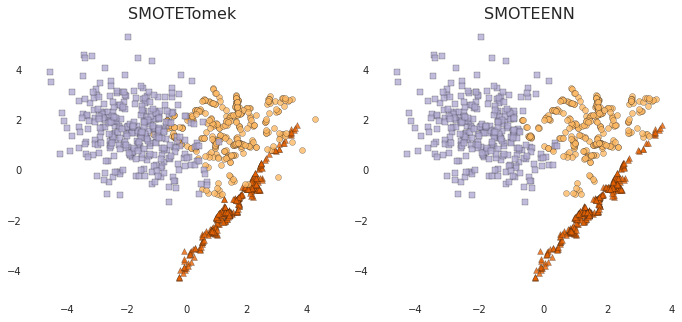

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
samplers = [
    FunctionSampler(),
    SMOTE(random_state=0),
    SMOTECDNN(random_state=0,cdnn=EditedCDNN(n_neighbors=21,sampling_strategy="all")),
        SMOTETomek(smote=SMOTE(random_state=0)),
            SMOTEENN(smote=SMOTE(random_state=0)),
    SMOTECDNN(random_state=0,cdnn=EditedCDNN(kind_sel='all')),

]

for ax, sampler in zip(axs.ravel(), samplers):
    title = "Original dataset" if isinstance(sampler, FunctionSampler) else None
    plot_resampling(X, y, sampler, ax, title=title)
fig.tight_layout()
fig.savefig('SMOTECDNN.pdf',dpi=1000)

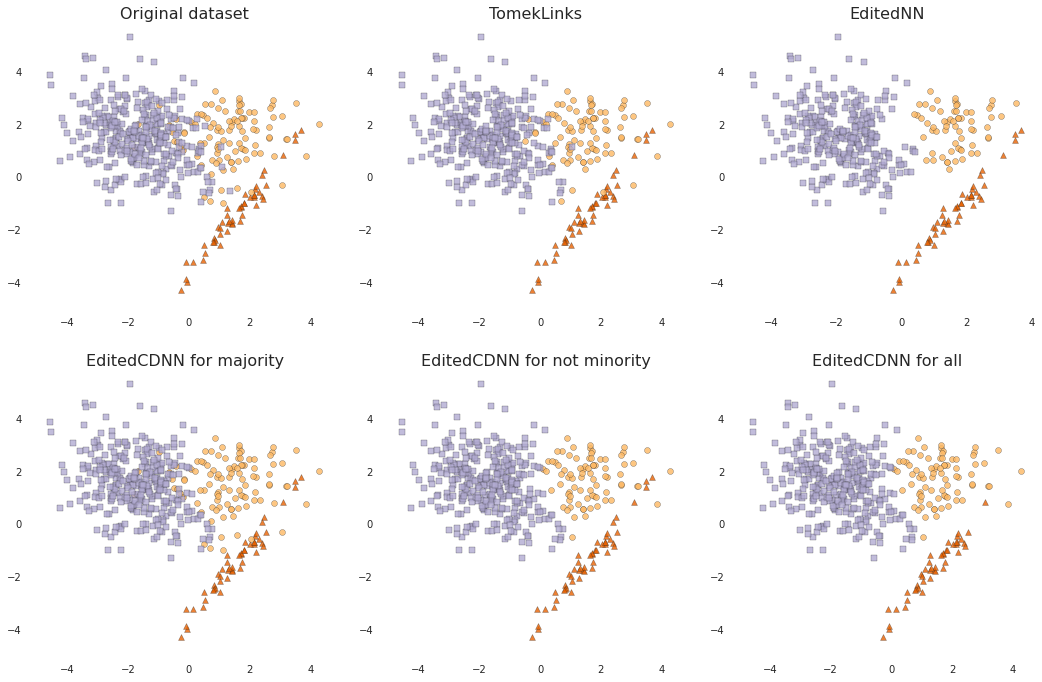

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours,TomekLinks

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
samplers = [
    FunctionSampler(),
    TomekLinks(),
    EditedNearestNeighbours(),
    EditedCDNN(n_neighbors=21,sampling_strategy='majority'),
    EditedCDNN(n_neighbors=21,sampling_strategy='not minority'),
EditedCDNN(n_neighbors=21,sampling_strategy='all')
]

i=0
title = ["Original dataset","TomekLinks","EditedNN","EditedCDNN for majority","EditedCDNN for not minority","EditedCDNN for all"]
for ax, sampler in zip(axs.ravel(), samplers):
    plot_resampling(X, y, sampler, ax, title=title[i])
    i+=1
fig.tight_layout()
fig.savefig('Undersampling.pdf',dpi=1000)

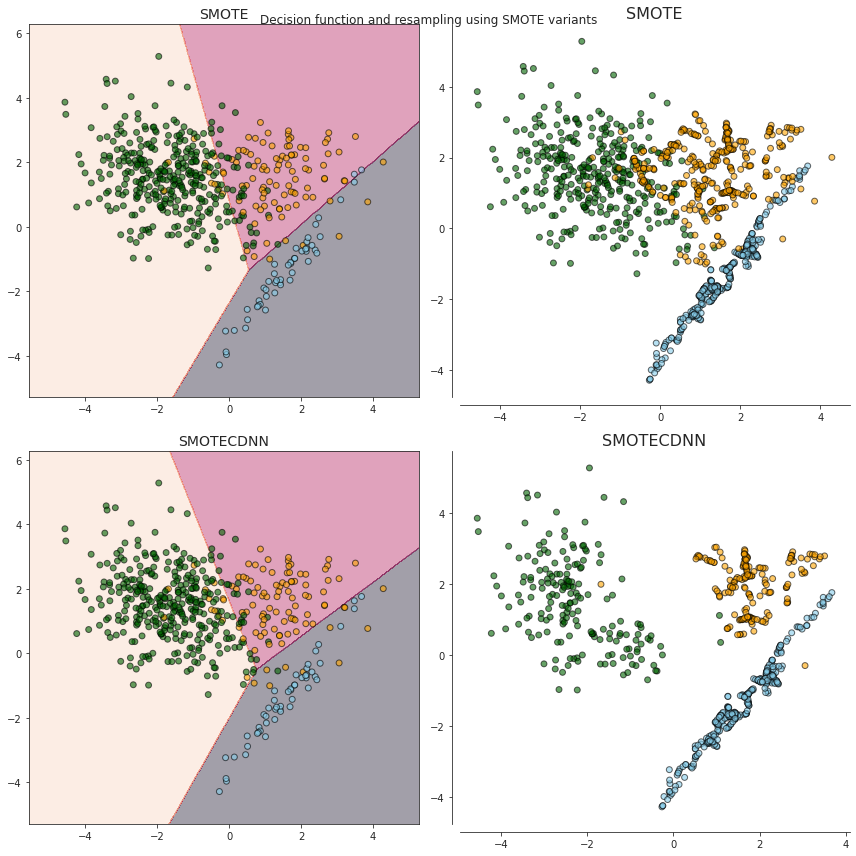

In [ ]:
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

samplers = [
    SMOTE(random_state=0),
    SMOTECDNN(random_state=0,cdnn=EditedCDNN(n_neighbors=21,kind_sel='all')),
]

for ax, sampler in zip(axs, samplers):
    model = make_pipeline(sampler, clf).fit(X, y)
    title = "Original dataset" if isinstance(sampler, FunctionSampler) else sampler.__class__.__name__
    plot_decision_function(
        X, y, clf, ax[0], title=title
    )
    plot_resampling(X, y, sampler, ax[1])

fig.suptitle("Decision function and resampling using SMOTE variants")
fig.tight_layout()

#ML experiments

In [ ]:
import pandas as pd
from scipy import stats


Mounted at /content/drive


In [ ]:
df=pd.read_csv(dir+'correlation.csv',index_col='name')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb

#Defining the models
classifiers = [KNeighborsClassifier(),
          LogisticRegression(random_state=1),
          MLPClassifier(random_state=1),
          SVC(kernel = 'rbf',random_state=1,probability=True),
          RandomForestClassifier(random_state=1),
          lgb.LGBMClassifier(random_state=1),
          ]
classifier_names = ['KNN','LR','MLP','SVM','RF','LGBM']


from imblearn.under_sampling import TomekLinks,EditedNearestNeighbours,RandomUnderSampler
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, RandomOverSampler, SVMSMOTE,SMOTE,KMeansSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.ensemble import EasyEnsembleClassifier,RUSBoostClassifier

i=1
balancer_names=["RandomUnderSampler","RandomOverSampler","SMOTE","ADASYN","BorderlineSMOTE","SVMSMOTE","SMOTEENN","SMOTETomek","SMOTECDNN21"]
balancers = [RandomUnderSampler(sampling_strategy=i,random_state=1),
            RandomOverSampler(sampling_strategy=i,random_state=1),
            SMOTE(sampling_strategy=i,random_state=1),
            ADASYN(sampling_strategy=i,random_state=1),
            BorderlineSMOTE(sampling_strategy=i,random_state=1),
            SVMSMOTE(sampling_strategy=i,random_state=1),
            SMOTEENN(smote=SMOTE(sampling_strategy=i,random_state=1)),
            SMOTETomek(smote=SMOTE(sampling_strategy=i,random_state=1)),
             SMOTECDNN(sampling_strategy=i,random_state=1,cdnn=EditedCDNN(n_neighbors=21,sampling_strategy='all')),]

scale=StandardScaler()

In [ ]:
repeats=5
n_folds=5
Result={}

# prepare the cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=1)

start= time.time()
X,y=df['data'],df['target']
y=LabelEncoder().fit_transform(y)
zipped_classifiers = zip(classifier_names,classifiers)
for name,clf in zipped_classifiers:
  R=cross_validate(clf, X, y, return_train_score=False,
  scoring=["accuracy","balanced_accuracy","precision","recall","average_precision","f1","roc_auc"],cv=cv )
  Result[dn+"|"+name+'|Origin']=pd.DataFrame(R)
  zipped_balancers = zip(balancer_names,balancers)
t = time.time() - start
print(f"Predict time for {dn}: {t:.3f}")

In [ ]:
output=pd.concat(Result).reset_index().groupby('level_0').mean()

#Result Analysis

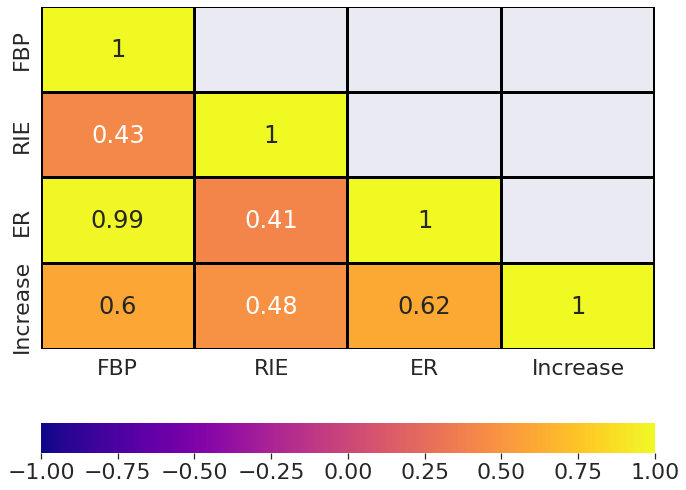

In [ ]:
def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(11, 9))
    sns.set(font_scale=2)
    # cm_bright = ListedColormap([ "#f7f7f7","#f7f7f7","#f7f7f7","#f7f7f7","#e66101","#fdb863", "#b2abd2"])#, "#00F0F0"])
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='plasma', linewidths=2, linecolor='black',cbar_kws={'orientation': 'horizontal'})
    ax.yaxis.label.set_size(20)
    plt.savefig('corr.pdf',dpi=500)

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

# Plotting with significance filter
corr = df.corr()                            # get correlation
p_values = corr_sig(df)                     # get p-Value
mask = np.invert(np.tril(p_values<0.05))    # mask - only get significant corr
plot_cor_matrix(corr,mask)

In [ ]:
R=pd.read_csv(dir+'Result.csv')
table=R.groupby(['d','m','s']).mean().reset_index()

In [ ]:
sc_list=["SMOTE","SMOTECDNN2","SMOTECDNN5","SMOTECDNN11","SMOTECDNN15","SMOTECDNN21","SMOTECDNN25"]
d_list=['ecoli','optical_digits', 'satimage', 'pen_digits','abalone', 'sick_euthyroid','spectrometer', 'car_eval_34',  'isolet', 'us_crime','yeast_ml8','scene',
  'libras_move','thyroid_sick','coil_2000','arrhythmia','solar_flare_m0', 'oil', 'car_eval_4','yeast_me2','wine_quality','ozone_level', 'mammography','abalone_19']
m_list=['KNN','LR','MLP','SVM','RF','LGBM']

In [ ]:
table_sensitivity=table[table.s.isin(sc_list)]
for i in ['test_balanced_accuracy']:
  print(i+'-------------------------------------------------------')
  display(table_sensitivity.pivot_table(index=['d'],columns=['s'],values=[i],margins=False).droplevel(0,1).rank(1,ascending=False).loc[d_list,sc_list].astype(int))
  display(table_sensitivity.pivot_table(index=['d'],columns=['s'],values=[i],margins=False).droplevel(0,1).round(4).loc[d_list,sc_list])

test_balanced_accuracy-------------------------------------------------------


s,SMOTE,SMOTECDNN2,SMOTECDNN5,SMOTECDNN11,SMOTECDNN15,SMOTECDNN21,SMOTECDNN25
d,,,,,,,
ecoli,7,5,6,3,4,2,1
optical_digits,3,4,5,1,6,7,2
satimage,7,5,2,1,6,3,4
pen_digits,2,7,5,3,6,1,4
abalone,7,6,5,4,1,3,2
sick_euthyroid,1,6,3,5,2,7,4
spectrometer,7,6,4,5,1,3,2
car_eval_34,1,6,7,5,2,3,4
isolet,7,2,1,3,4,5,6


s,SMOTE,SMOTECDNN2,SMOTECDNN5,SMOTECDNN11,SMOTECDNN15,SMOTECDNN21,SMOTECDNN25
d,,,,,,,
ecoli,0.8486,0.8685,0.8671,0.8711,0.8703,0.8730,0.8807
optical_digits,0.9652,0.9651,0.9651,0.9662,0.9649,0.9647,0.9658
satimage,0.8198,0.8323,0.8370,0.8371,0.8258,0.8360,0.8357
pen_digits,0.9824,0.9818,0.9821,0.9823,0.9818,0.9829,0.9823
abalone,0.7395,0.7716,0.7770,0.7819,0.7843,0.7833,0.7834
sick_euthyroid,0.8526,0.8459,0.8483,0.8462,0.8485,0.8456,0.8475
spectrometer,0.8964,0.9067,0.9080,0.9073,0.9166,0.9085,0.9120
car_eval_34,0.9765,0.9719,0.9702,0.9725,0.9755,0.9742,0.9740
isolet,0.9460,0.9545,0.9553,0.9543,0.9525,0.9522,0.9507


In [ ]:
s_list=["Origin","RandomUnderSampler","RandomOverSampler","SMOTE","ADASYN","BorderlineSMOTE","SVMSMOTE","SMOTEENN","SMOTETomek","SMOTECDNN21"]
table=table[table.s.isin(s_list)]

In [ ]:
for i in ['test_balanced_accuracy','test_average_precision','test_G_mean','test_recall','test_f1']:
  print(i+'-------------------------------------------------------')
  display(table.pivot_table(index=['d'],columns=['s'],values=[i],margins=False).droplevel(0,1).rank(1,ascending=False,method ='dense').loc[d_list,s_list].astype(int))
  display(table.pivot_table(index=['d'],columns=['s'],values=[i],margins=False).droplevel(0,1).round(4).loc[d_list,s_list])

test_balanced_accuracy-------------------------------------------------------


s,Origin,RandomUnderSampler,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE,SMOTEENN,SMOTETomek,SMOTECDNN21
d,,,,,,,,,,
ecoli,10,2,9,7,8,6,4,3,5,1
optical_digits,9,1,4,5,7,8,2,3,5,6
satimage,10,9,4,5,7,8,3,1,6,2
pen_digits,8,5,4,2,7,9,6,3,2,1
abalone,10,3,8,5,4,7,9,2,6,1
sick_euthyroid,10,8,6,1,4,2,5,9,3,7
spectrometer,10,9,8,6,3,7,5,1,4,2
car_eval_34,9,8,7,1,5,4,2,6,1,3
isolet,9,4,6,5,7,8,1,2,5,3


s,Origin,RandomUnderSampler,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE,SMOTEENN,SMOTETomek,SMOTECDNN21
d,,,,,,,,,,
ecoli,0.6958,0.8728,0.8360,0.8486,0.8479,0.8499,0.8529,0.8704,0.8509,0.8730
optical_digits,0.9448,0.9711,0.9657,0.9652,0.9584,0.9565,0.9704,0.9676,0.9652,0.9647
satimage,0.6749,0.8034,0.8218,0.8198,0.8173,0.8101,0.8257,0.8364,0.8179,0.8360
pen_digits,0.9682,0.9818,0.9820,0.9824,0.9760,0.9671,0.9772,0.9822,0.9824,0.9829
abalone,0.5259,0.7656,0.7255,0.7395,0.7401,0.7316,0.7233,0.7825,0.7362,0.7833
sick_euthyroid,0.7506,0.8427,0.8486,0.8526,0.8509,0.8511,0.8495,0.8422,0.8509,0.8456
spectrometer,0.8134,0.8787,0.8877,0.8964,0.9071,0.8899,0.8986,0.9178,0.8994,0.9085
car_eval_34,0.9092,0.9442,0.9721,0.9765,0.9727,0.9732,0.9743,0.9725,0.9765,0.9742
isolet,0.9049,0.9504,0.9428,0.9460,0.9384,0.9303,0.9568,0.9541,0.9460,0.9522


test_average_precision-------------------------------------------------------


s,Origin,RandomUnderSampler,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE,SMOTEENN,SMOTETomek,SMOTECDNN21
d,,,,,,,,,,
ecoli,1,10,6,3,9,7,4,8,5,2
optical_digits,1,9,4,2,7,8,5,3,2,6
satimage,1,10,3,2,6,7,5,8,4,9
pen_digits,1,6,2,3,7,9,8,4,3,5
abalone,10,9,8,4,7,3,2,5,6,1
sick_euthyroid,1,10,6,4,7,3,2,9,5,8
spectrometer,2,10,1,5,9,7,3,4,6,8
car_eval_34,1,9,3,6,4,5,2,7,6,8
isolet,1,7,2,3,5,6,4,8,3,9


s,Origin,RandomUnderSampler,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE,SMOTEENN,SMOTETomek,SMOTECDNN21
d,,,,,,,,,,
ecoli,0.6563,0.5923,0.6348,0.6472,0.6282,0.6321,0.6455,0.6297,0.6441,0.6546
optical_digits,0.9784,0.9592,0.9757,0.9773,0.9715,0.9711,0.9752,0.9764,0.9773,0.9748
satimage,0.5735,0.4989,0.5611,0.5613,0.5340,0.5317,0.5524,0.5098,0.5595,0.5013
pen_digits,0.9712,0.9547,0.9612,0.9607,0.9173,0.9028,0.9135,0.9599,0.9607,0.9596
abalone,0.2800,0.2816,0.2926,0.2979,0.2957,0.2982,0.3007,0.2968,0.2967,0.3030
sick_euthyroid,0.7176,0.5906,0.6419,0.6441,0.6387,0.6468,0.6529,0.6301,0.6439,0.6354
spectrometer,0.8430,0.7093,0.8431,0.8271,0.8114,0.8160,0.8408,0.8359,0.8223,0.8133
car_eval_34,0.9418,0.8791,0.9176,0.9031,0.9095,0.9067,0.9221,0.8998,0.9031,0.8935
isolet,0.9453,0.8611,0.9214,0.9041,0.8938,0.8907,0.9032,0.8273,0.9041,0.8070


test_G_mean-------------------------------------------------------


s,Origin,RandomUnderSampler,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE,SMOTEENN,SMOTETomek,SMOTECDNN21
d,,,,,,,,,,
ecoli,10,9,8,3,7,5,2,6,1,4
optical_digits,3,9,4,2,8,7,6,1,2,5
satimage,10,9,1,2,5,6,4,7,3,8
pen_digits,1,8,5,2,7,9,6,4,2,3
abalone,10,3,9,4,5,7,8,2,6,1
sick_euthyroid,10,9,6,4,5,2,1,8,3,7
spectrometer,9,10,3,4,6,8,2,1,5,7
car_eval_34,5,9,6,1,4,3,2,8,1,7
isolet,1,9,2,4,5,6,3,7,4,8


s,Origin,RandomUnderSampler,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE,SMOTEENN,SMOTETomek,SMOTECDNN21
d,,,,,,,,,,
ecoli,0.4815,0.5925,0.6074,0.6289,0.6157,0.6234,0.6292,0.6168,0.6320,0.6265
optical_digits,0.9300,0.8729,0.9285,0.9313,0.9153,0.9198,0.9239,0.9321,0.9313,0.9276
satimage,0.4573,0.4940,0.5864,0.5803,0.5662,0.5630,0.5796,0.5551,0.5799,0.5520
pen_digits,0.9526,0.9165,0.9437,0.9462,0.9226,0.9140,0.9235,0.9445,0.9462,0.9458
abalone,0.1029,0.4326,0.4011,0.4196,0.4177,0.4127,0.4076,0.4490,0.4139,0.4531
sick_euthyroid,0.5692,0.5847,0.6406,0.6462,0.6413,0.6601,0.6686,0.6155,0.6467,0.6255
spectrometer,0.7421,0.6540,0.8020,0.7945,0.7902,0.7795,0.8023,0.8099,0.7944,0.7890
car_eval_34,0.8778,0.6958,0.8644,0.8860,0.8814,0.8833,0.8853,0.8185,0.8860,0.8547
isolet,0.8643,0.7203,0.8534,0.8410,0.8316,0.8285,0.8423,0.7593,0.8410,0.7353


test_recall-------------------------------------------------------


s,Origin,RandomUnderSampler,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE,SMOTEENN,SMOTETomek,SMOTECDNN21
d,,,,,,,,,,
ecoli,8,1,7,6,4,4,4,2,5,3
optical_digits,9,1,4,5,7,8,2,3,5,6
satimage,10,6,5,7,4,9,3,2,8,1
pen_digits,9,1,6,5,3,8,2,7,5,4
abalone,10,3,8,5,4,7,9,1,6,2
sick_euthyroid,10,1,7,5,3,8,9,2,6,4
spectrometer,10,2,9,6,4,8,7,1,5,3
car_eval_34,9,1,3,5,6,8,7,2,5,4
isolet,9,1,7,5,6,8,4,3,5,2


s,Origin,RandomUnderSampler,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE,SMOTEENN,SMOTETomek,SMOTECDNN21
d,,,,,,,,,,
ecoli,0.4143,0.9286,0.7762,0.7952,0.8095,0.8095,0.8095,0.8810,0.8000,0.8762
optical_digits,0.8926,0.9735,0.9431,0.9404,0.9314,0.9245,0.9579,0.9458,0.9404,0.9404
satimage,0.3728,0.8100,0.8125,0.8059,0.8162,0.7876,0.8224,0.8825,0.7971,0.8876
pen_digits,0.9397,0.9845,0.9774,0.9774,0.9812,0.9618,0.9825,0.9773,0.9774,0.9787
abalone,0.0674,0.8154,0.6514,0.6864,0.7000,0.6586,0.6219,0.8522,0.6821,0.8339
sick_euthyroid,0.5125,0.8699,0.8176,0.8289,0.8375,0.8034,0.7812,0.8505,0.8256,0.8334
spectrometer,0.6333,0.8593,0.7926,0.8185,0.8444,0.8148,0.8185,0.8630,0.8259,0.8481
car_eval_34,0.8220,0.9975,0.9900,0.9813,0.9726,0.9725,0.9725,0.9937,0.9813,0.9838
isolet,0.8158,0.9764,0.9058,0.9208,0.9064,0.8875,0.9447,0.9675,0.9208,0.9731


test_f1-------------------------------------------------------


s,Origin,RandomUnderSampler,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE,SMOTEENN,SMOTETomek,SMOTECDNN21
d,,,,,,,,,,
ecoli,10,9,7,2,6,4,3,8,1,5
optical_digits,3,9,4,2,8,7,6,1,2,5
satimage,10,9,1,3,6,5,4,7,2,8
pen_digits,1,8,5,2,7,9,6,4,2,3
abalone,10,8,9,3,6,5,4,2,7,1
sick_euthyroid,9,10,5,4,6,2,1,8,3,7
spectrometer,9,10,3,4,6,8,2,1,5,7
car_eval_34,5,9,6,2,4,3,1,8,2,7
isolet,1,9,2,4,5,6,3,7,4,8


s,Origin,RandomUnderSampler,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE,SMOTEENN,SMOTETomek,SMOTECDNN21
d,,,,,,,,,,
ecoli,0.4564,0.5369,0.5786,0.6066,0.5875,0.5972,0.6042,0.5780,0.6099,0.5914
optical_digits,0.9284,0.8664,0.9257,0.9294,0.9115,0.9169,0.9191,0.9302,0.9294,0.9256
satimage,0.4235,0.4368,0.5447,0.5398,0.5209,0.5221,0.5370,0.4990,0.5414,0.4942
pen_digits,0.9522,0.9118,0.9402,0.9432,0.9127,0.9062,0.9144,0.9414,0.9432,0.9426
abalone,0.0927,0.3582,0.3533,0.3704,0.3649,0.3680,0.3702,0.3705,0.3644,0.3804
sick_euthyroid,0.5612,0.5378,0.6117,0.6168,0.6093,0.6382,0.6528,0.5759,0.6178,0.5914
spectrometer,0.7190,0.6228,0.7941,0.7879,0.7833,0.7681,0.7965,0.8029,0.7877,0.7808
car_eval_34,0.8694,0.6504,0.8467,0.8756,0.8716,0.8741,0.8776,0.7984,0.8756,0.8418
isolet,0.8594,0.6871,0.8481,0.8316,0.8215,0.8186,0.8322,0.7355,0.8316,0.7060


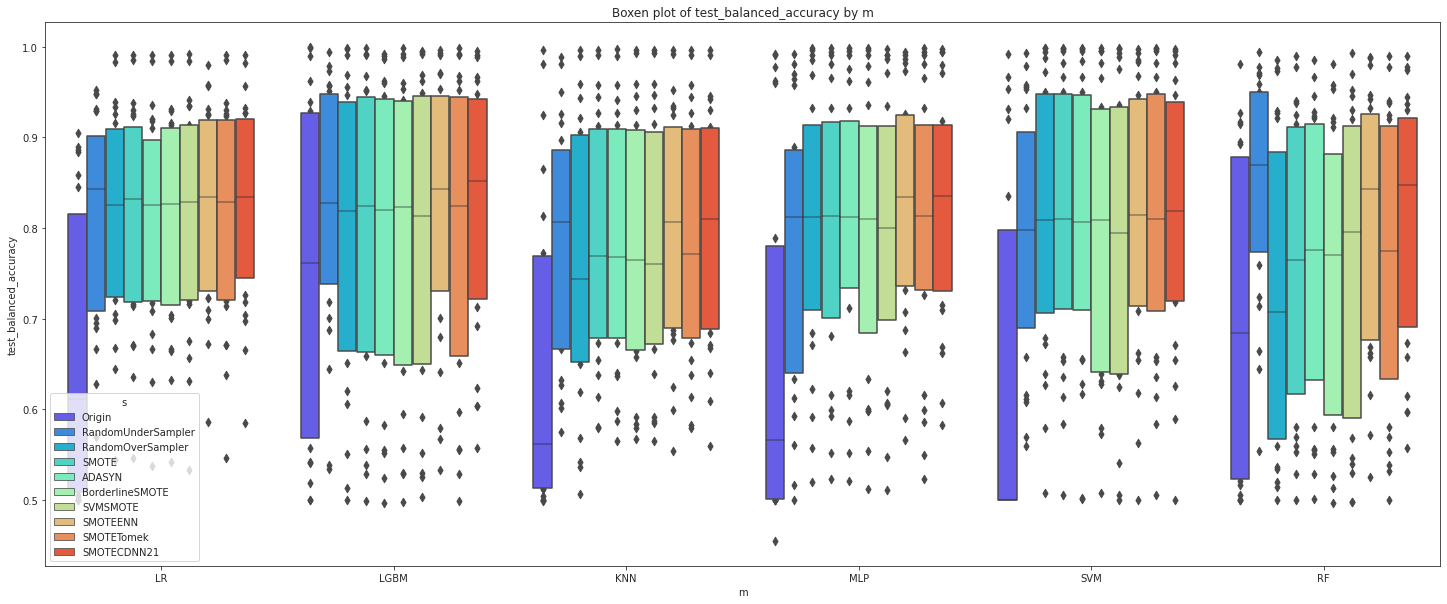

In [ ]:
utils_plot.boxen_plot(data,cat_v='m',con_v='test_balanced_accuracy',hue_v='s',figsize=(25,10))

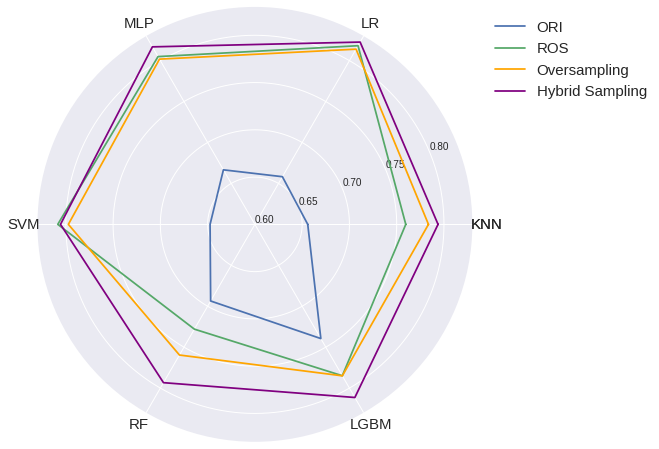

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# categories = list(temp.s)
# categories = [*categories, categories[0]]
categories =['KNN',	'LR',	'MLP',	'SVM',	'RF',	'LGBM' ,'KNN']


o=[0.6559,	0.6582,	0.6666,	0.6474,	0.6936,	0.7395,0.6559]
rus=[0.7802,	0.8138,	0.7759,	0.7869,	0.8404,	0.8159,0.7802]
ros=[0.7596,	0.8182,	0.8049,	0.8085,	0.728,	0.7849,0.7596]
# os=[0.782775,	0.813025,	0.799525,	0.79615	,0.75645,	0.7836,0.782775]
os=[0.7836,	0.8140,	0.8018,	0.7973	,0.7596,	0.7850,0.7836]
hs=[0.793733333,	0.822633333	,0.8168,	0.805633333,	0.793366667	,0.811466667,0.793733333]

label_loc = np.linspace(start=0, stop=2* np.pi, num=len(categories))

plt.figure(figsize=(10, 8))
plt.subplot(polar=True)

plt.plot(label_loc,o, label='ORI')
# plt.plot(label_loc,rus, label='RUS')
plt.plot(label_loc,ros, label='ROS')
plt.plot(label_loc,os, label='Oversampling',color="orange")
plt.plot(label_loc,hs, label='Hybrid Sampling',color="purple")

# plt.title('Sampling algorithms comparison', size=15)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories,fontsize=15)
plt.legend(loc=2,bbox_to_anchor=(1.02, 1),fontsize=15)
# plt.ylabel('Balanced Accuracy',loc='top')
plt.ylim(0.6,0.83)
plt.savefig('radar.pdf',dpi=500, bbox_inches = 'tight')

Lollipop plot for Ori SMOTE and SMOTECDNN

In [ ]:
lp_r=table[['d','s','test_balanced_accuracy']]
lp_r=lp_r[lp_r.s.isin(['Origin','SMOTE','SMOTECDNN21'])].groupby(['s','d']).mean().reset_index()
lp_plot=lp_r.pivot_table(values='test_balanced_accuracy',index='d',columns='s').reset_index()
lp_plot=lp_plot.sort_values(by='Origin')
lp_plot=pd.merge(lp_plot,sdR)

def myfunc(p):
    if p<0.0010001:
        star="***"
    elif p<0.010001:
        star="**"
    elif p<0.050001:
        star="*"
    else:
        star=""
    return star

lp_plot['star'] = lp_plot['p'].apply(lambda x: myfunc(x))

lp_plot['dn']=lp_plot['d']+lp_plot['star']

In [ ]:
lp_plot_d=lp_plot.copy()

In [ ]:
lp_plot=pd.concat([lp_plot_m,lp_plot_d])

In [ ]:
s1=lp_plot_d['Origin']
s2=lp_plot_d['SMOTE']
s3=lp_plot_d['SMOTECDNN21']

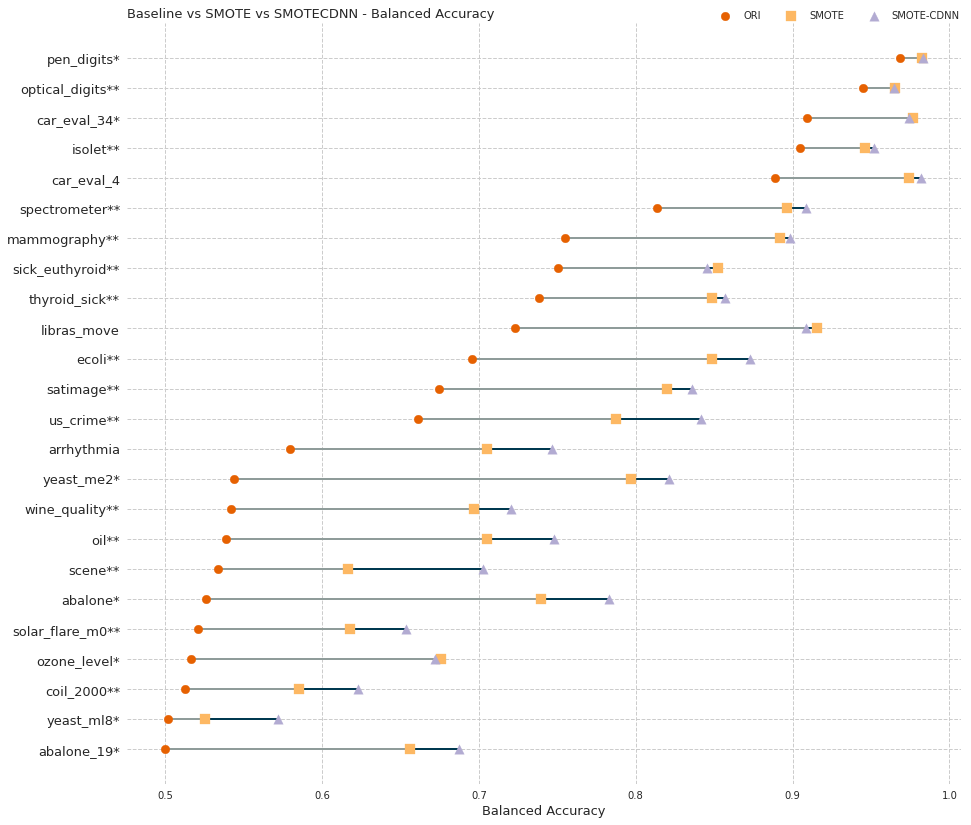

In [ ]:
plt.figure(figsize = (14, 12))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
my_range=range(1,len(s1)+1)

ax = plt.axes(frameon=False)
plt.hlines(y=my_range, xmin=s1, xmax=s2, color='#8f9c9a', lw =2)
plt.hlines(y=my_range, xmin=s2, xmax=s3, color='#003950', lw =2)
plt.scatter(s1, my_range, color="#e66101", s=75, marker='o',label='ORI', zorder=3)
plt.scatter(s2, my_range, color="#fdb863", s=95, marker='s',label='SMOTE', zorder=3)
plt.scatter(s3, my_range, color= "#b2abd2", s=90, marker='^',label='SMOTE-CDNN', zorder=3)


plt.legend(ncol=3, bbox_to_anchor=(1.01, 0.992), loc="lower right", frameon=False)
plt.yticks(my_range, lp_plot_d['dn'],fontsize=13)
plt.gca().yaxis.set_label_coords(-0.1,1.02)
# plt.yticks([])
plt.title("Baseline vs SMOTE vs SMOTECDNN - Balanced Accuracy", loc='left', fontsize=13)
plt.xlabel('Balanced Accuracy', fontsize=13)
plt.tight_layout()
plt.savefig("lollipop_d.pdf",dpi=500)
# plt.show()

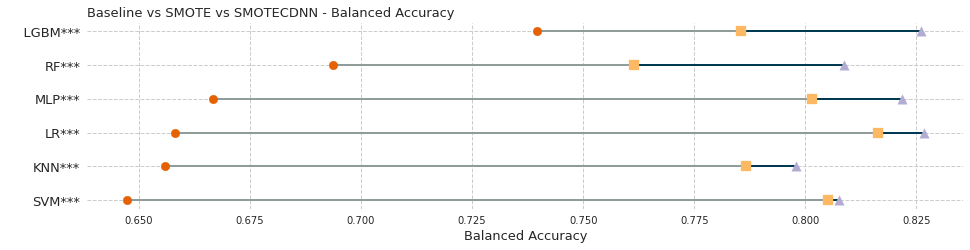

In [ ]:
plt.figure(figsize = (14, 4))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
my_range=range(1,len(s1)+1)

ax = plt.axes(frameon=False)
plt.hlines(y=my_range, xmin=s1, xmax=s2, color='#8f9c9a', lw =2)
plt.hlines(y=my_range, xmin=s2, xmax=s3, color='#003950', lw =2)
plt.scatter(s1, my_range, color="#e66101", s=75, marker='o',label='ORI', zorder=3)
plt.scatter(s2, my_range, color="#fdb863", s=95, marker='s',label='SMOTE', zorder=3)
plt.scatter(s3, my_range, color= "#b2abd2", s=90, marker='^',label='SMOTE-CDNN', zorder=3)


# plt.legend(ncol=3, bbox_to_anchor=(1., 1.01), loc="lower right", frameon=False)
plt.gca().yaxis.set_label_coords(0.5,1.02)
plt.yticks(my_range, m_names,fontsize=13)
# plt.yticks([])
plt.title("Baseline vs SMOTE vs SMOTECDNN - Balanced Accuracy", loc='left', fontsize=13)
plt.xlabel('Balanced Accuracy', fontsize=13)
plt.tight_layout()
plt.savefig("lollipop_m.pdf",dpi=500)
# plt.show()